# Import libraries and model

In [ ]:
from os import listdir
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gc
import gensim.downloader as api

import torch
import torch.nn as nn

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from math import ceil
import torch.optim as optim

import matplotlib.pyplot as plt
import datetime

nltk.download('stopwords')
nltk.download('wordnet')

# Load GloVe model with Gensim's API - Twitter specific embedding
embeddings_model = api.load("glove-twitter-200")  # 200-dimensional GloVe embeddings

#To check that T4 GPU is connected
#!nvidia-smi

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\berge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\berge\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data preprocessing and and feature extractions

## Preprocessing training set

In [2]:
# Read all training files and concatenate them into one dataframe

def load_data_frame(dirName):
    li = []
    i = 0
    for filename in listdir(dirName):
        if filename != '.ipynb_checkpoints':
            print(filename)
            df = pd.read_csv(dirName + "/" + filename)
            df.drop(columns=['Timestamp'], inplace=True)
            # Drop unused column(s)
            df['ID'] = df['MatchID'].astype(str) + '_' + df['PeriodID'].astype(str)
            #df['MatchID'] = str(i)
            # Makes sure that the match IDs are ordered from 0,1,2... with no missing values
            i+=1
            li.append(df)
    df = pd.concat(li, ignore_index=True)
    print("Loaded the dataframe from the folder " + dirName + "!")
    return df

In [3]:
df = load_data_frame("train_tweets")

ArgentinaBelgium72.csv
ArgentinaGermanyFinal77.csv
AustraliaNetherlands29.csv
AustraliaSpain34.csv
BelgiumSouthKorea59.csv
CameroonBrazil36.csv
FranceGermany70.csv
FranceNigeria66.csv
GermanyAlgeria67.csv
GermanyBrazil74.csv
GermanyUSA57.csv
HondurasSwitzerland54.csv
MexicoCroatia37.csv
NetherlandsChile35.csv
PortugalGhana58.csv
USASlovenia2010.csv
Loaded the dataframe from the folder train_tweets!


In [4]:
# Preprocessing of tweet
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenization
    words = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

def preprocess_data_frame(df):
    df['Tweet'] = df['Tweet'].apply(preprocess_text)
    df

In [5]:
# Apply preprocessing to each tweet
preprocess_data_frame(df)
df

,ID,MatchID,PeriodID,EventType,Tweet
0,11_0,11,0,0,rt woridcup argentina v belgium win httptcoleu...
1,11_0,11,0,0,elijahman_ time focus belgium winning world cup
2,11_0,11,0,0,rt fifaworldcup global stadium joinin worldcup...
3,11_0,11,0,0,rt catholicnewssvc popefrancis uhoh argentina ...
4,11_0,11,0,0,rt soccerdotcom score v bel well award messisi...
...,...,...,...,...,...
5056045,18_129,18,129,0,rt nytimes fifa world cup final score u sloven...
5056046,18_129,18,129,0,ugh shouldve usa worldcup
5056047,18_129,18,129,0,rt jaclynkeough ha rt someecards id rather die...
5056048,18_129,18,129,0,rt gustavaulia many surprise worldcup timewoww...


## Tweet Embeddings on training set

In [6]:
# Get vector tweet embeddings
# TODOOOOOOOOOOOOOOOO maybe instead of avg word embedding for each tweet can get sentence
#   embeddings to retain more information
#   -> can try more complex functions here
#   -> avg embedding of each word for a tweet is fine for now, maybe works well enough

# Function to compute the average word vector for a tweet
def get_avg_embedding(tweet, model, vector_size=200):
    words = tweet.split()  # Tokenize by whitespace
    word_vectors = [model[word] for word in words if word in model]
    if not word_vectors:  # If no words in the tweet are in the vocabulary, return a zero vector
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)

def get_tweet_embeddings(df, vector_size):
    tweet_vectors = np.vstack([get_avg_embedding(tweet, embeddings_model, vector_size) for tweet in df['Tweet']])
    tweet_df = pd.DataFrame(tweet_vectors)
    print("Created vector tweet embeddings!")
    return tweet_df

In [7]:
# Crashes after using all available RAM :( on google colab

# Obtain vector tweet embeddings
vector_size = 200  # Adjust based on the chosen GloVe model
tweet_df = get_tweet_embeddings(df, vector_size)
tweet_df.head()

Created vector tweet embeddings!


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.370323,0.531700,-0.057301,0.001945,-0.177691,-0.039466,-0.318336,0.049636,0.338458,-0.102866,...,-0.320222,-0.201019,-0.065383,-0.042177,-0.264181,-0.016805,0.228576,-0.104629,-0.364003,0.273960
1,0.113964,0.179678,0.092712,-0.179685,-0.109610,0.123447,0.213493,-0.063245,0.183947,-0.246134,...,-0.133157,-0.330765,-0.093205,0.016202,0.008341,-0.004910,0.089336,0.079373,0.045625,0.062633
2,-0.048559,0.302010,0.049827,-0.275527,0.148541,-0.116081,-0.253812,-0.134411,0.196322,-0.021833,...,-0.047611,-0.088304,-0.101538,-0.114711,-0.299336,0.137398,0.111959,0.274555,-0.211163,0.208941
3,0.201836,0.249383,-0.066594,-0.073885,-0.133152,-0.033296,0.059994,-0.024996,0.046238,-0.053954,...,-0.148899,-0.085644,-0.126253,0.012219,-0.313125,-0.060006,0.204233,0.000428,-0.298889,0.278378
4,0.156795,0.375538,-0.025449,-0.044731,0.036281,0.043673,0.047919,0.148287,0.163690,0.090444,...,-0.238058,-0.065272,0.043676,0.039759,0.002273,0.056147,0.030378,-0.064882,-0.192816,0.016506


In [8]:
# No need for Tweet column since we have its corresponding vector embedding
df.drop(columns=['Tweet'], inplace=True)

# Attach the vectors into the original dataframe
df = pd.concat([df, tweet_df], axis=1)

# By now should have df with columns: ID, match id, period id, Event Type, tweet_vector. Tweet_vector is just 200 columns
df.head()

,ID,MatchID,PeriodID,EventType,0,1,2,3,4,5,...,190,191,192,193,194,195,196,197,198,199
0,11_0,11,0,0,0.370323,0.531700,-0.057301,0.001945,-0.177691,-0.039466,...,-0.320222,-0.201019,-0.065383,-0.042177,-0.264181,-0.016805,0.228576,-0.104629,-0.364003,0.273960
1,11_0,11,0,0,0.113964,0.179678,0.092712,-0.179685,-0.109610,0.123447,...,-0.133157,-0.330765,-0.093205,0.016202,0.008341,-0.004910,0.089336,0.079373,0.045625,0.062633
2,11_0,11,0,0,-0.048559,0.302010,0.049827,-0.275527,0.148541,-0.116081,...,-0.047611,-0.088304,-0.101538,-0.114711,-0.299336,0.137398,0.111959,0.274555,-0.211163,0.208941
3,11_0,11,0,0,0.201836,0.249383,-0.066594,-0.073885,-0.133152,-0.033296,...,-0.148899,-0.085644,-0.126253,0.012219,-0.313125,-0.060006,0.204233,0.000428,-0.298889,0.278378
4,11_0,11,0,0,0.156795,0.375538,-0.025449,-0.044731,0.036281,0.043673,...,-0.238058,-0.065272,0.043676,0.039759,0.002273,0.056147,0.030378,-0.064882,-0.192816,0.016506


In [9]:
# Group the tweets into their corresponding periods to generate an average embedding vector for each period
# so there are no duplicate period id rows per match.
# It decreases the size of data and makes it easier to fit into LSTM model
def group_data_frame_by_periods(df):
    df = df.groupby(['MatchID', 'PeriodID', 'ID']).mean().reset_index()
    #df.drop(columns=['ID'], inplace=True) 
    df['MatchID'] = df['MatchID'].astype(int)
    df['PeriodID'] = df['PeriodID'].astype(int)
    # need to convert to int before sorting
    df.sort_values(by=['MatchID', 'PeriodID'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    print("Grouped dataframe by periods!")
    return df


In [10]:
df = group_data_frame_by_periods(df)
df

Grouped dataframe by periods!


,MatchID,PeriodID,ID,EventType,0,1,2,3,4,5,...,190,191,192,193,194,195,196,197,198,199
0,0,0,0_0,0.0,0.142700,0.273355,0.024052,-0.100410,-0.056623,0.047082,...,-0.095398,-0.058165,0.056072,-0.000830,-0.073885,-0.005746,0.174125,0.093547,-0.009831,0.145556
1,0,1,0_1,0.0,0.155795,0.274697,0.022707,-0.114188,-0.078044,0.046390,...,-0.094809,-0.053387,0.067755,-0.000557,-0.106459,0.007881,0.165998,0.100027,-0.008115,0.127290
2,0,2,0_2,0.0,0.149349,0.291958,0.035742,-0.123525,-0.054195,0.042744,...,-0.112641,-0.056553,0.073958,0.001823,-0.102801,0.003312,0.174950,0.081542,-0.008284,0.130799
3,0,3,0_3,0.0,0.160484,0.263250,0.003070,-0.158384,-0.055241,0.047692,...,-0.122675,-0.047729,0.064131,0.015966,-0.102371,0.001360,0.156838,0.095372,0.014287,0.130726
4,0,4,0_4,0.0,0.159678,0.268265,-0.034739,-0.143102,-0.086689,0.054459,...,-0.117430,-0.039636,0.030168,0.018995,-0.101448,0.020565,0.149877,0.092729,-0.011608,0.149763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,19,125,19_125,1.0,0.041150,0.267610,0.052960,-0.197763,0.104450,0.025712,...,-0.058006,-0.074136,-0.033716,0.011847,-0.041860,0.024191,0.167323,0.122392,-0.054058,0.158443
2133,19,126,19_126,1.0,0.044753,0.266801,0.058579,-0.202625,0.093912,0.024470,...,-0.050856,-0.076830,-0.019953,0.005234,-0.050930,0.036127,0.161945,0.129341,-0.063787,0.172965
2134,19,127,19_127,1.0,0.048542,0.271988,0.051762,-0.197929,0.092518,0.020690,...,-0.054085,-0.077008,-0.020153,0.008492,-0.052610,0.036094,0.162711,0.131641,-0.069869,0.174006
2135,19,128,19_128,1.0,0.051801,0.269485,0.051750,-0.198183,0.088989,0.019420,...,-0.049065,-0.073360,-0.026281,0.006967,-0.056533,0.039534,0.158736,0.124636,-0.077828,0.173008


## Preprocessing evaluation set

In [11]:
df_eval = load_data_frame("eval_tweets")
df_eval

GermanyGhana32.csv
GermanySerbia2010.csv
GreeceIvoryCoast44.csv
NetherlandsMexico64.csv
Loaded the dataframe from the folder eval_tweets!


,ID,MatchID,PeriodID,Tweet
0,6_0,6,0,I Finally get to see Germany play\n#GER 🇩🇪⚽🏆
1,6_0,6,0,RT @Wor1dCup2014: If Any of the Boateng Brothe...
2,6_0,6,0,Fascinated for this #GERvsGHA match. This will...
3,6_0,6,0,: #GER and #GHA in a few.
4,6_0,6,0,BOATENG GRUDGE MATCH: 21/2 for Jermaine to sco...
...,...,...,...,...
1072923,15_125,15,125,Dutch deserve to be in last 8.Keep their nerve...
1072924,15_125,15,125,RT @GeniusFootball: RETWEET if you think #MEX ...
1072925,15_125,15,125,"Hold your head high Mexico, played beautifully..."
1072926,15_125,15,125,RT @TheWorIdCup: Mexico fans right now... http...


In [12]:
preprocess_data_frame(df_eval)
df_eval

,ID,MatchID,PeriodID,Tweet
0,6_0,6,0,finally get see germany play ger
1,6_0,6,0,rt wordcup boateng brother score today well gi...
2,6_0,6,0,fascinated gervsgha match tell u lot chance us...
3,6_0,6,0,ger gha
4,6_0,6,0,boateng grudge match jermaine score ger kevinp...
...,...,...,...,...
1072923,15_125,15,125,dutch deserve last keep nerve till end turnove...
1072924,15_125,15,125,rt geniusfootball retweet think mex deserved w...
1072925,15_125,15,125,hold head high mexico played beautifully last ...
1072926,15_125,15,125,rt theworidcup mexico fan right httptcozfmwxiatw


## Tweet Embeddings on training set

In [13]:
tweet_df_eval = get_tweet_embeddings(df_eval, vector_size)
tweet_df_eval.head()

Created vector tweet embeddings!


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.183428,0.351652,-0.059248,-0.182003,0.081787,0.131392,0.513264,0.108436,0.235608,0.015548,...,-0.126687,-0.086776,0.224327,-0.298100,-0.039604,-0.170743,0.212588,-0.165797,-0.058123,0.241740
1,0.252394,0.291525,-0.054652,0.019181,0.082992,-0.067042,0.106594,0.062850,0.114198,0.168639,...,-0.273192,-0.043879,0.165205,0.012790,-0.035947,-0.023603,0.090462,0.079817,-0.096872,0.275643
2,0.133759,0.340722,-0.202986,-0.155269,-0.052570,0.217507,0.175424,0.069934,0.147071,0.122774,...,-0.041979,0.041901,0.099874,-0.158076,0.035020,0.158700,0.197988,0.048215,0.172673,0.004555
3,0.132508,0.662775,0.105600,-0.120870,0.362255,-0.073177,-0.708465,0.064674,0.255179,0.385500,...,0.142360,-0.204735,0.413800,-0.161360,-0.254585,0.116110,0.463215,0.004530,-0.096614,0.372920
4,0.349205,0.474341,-0.059732,-0.133805,0.189881,0.259303,0.060578,0.032346,-0.050215,0.255715,...,-0.366065,0.063324,0.365045,-0.195428,-0.176695,-0.036868,0.357725,-0.104471,0.130819,0.210772


In [14]:
# No need for Tweet column since we have its corresponding vector embedding
df_eval.drop(columns=['Tweet'], inplace=True)

# Attach the vectors into the original dataframe
df_eval = pd.concat([df_eval, tweet_df_eval], axis=1)

# By now should have df with columns: ID, match id, period id, Event Type, tweet_vector. Tweet_vector is just 200 columns
df_eval.head()

,ID,MatchID,PeriodID,0,1,2,3,4,5,6,...,190,191,192,193,194,195,196,197,198,199
0,6_0,6,0,0.183428,0.351652,-0.059248,-0.182003,0.081787,0.131392,0.513264,...,-0.126687,-0.086776,0.224327,-0.298100,-0.039604,-0.170743,0.212588,-0.165797,-0.058123,0.241740
1,6_0,6,0,0.252394,0.291525,-0.054652,0.019181,0.082992,-0.067042,0.106594,...,-0.273192,-0.043879,0.165205,0.012790,-0.035947,-0.023603,0.090462,0.079817,-0.096872,0.275643
2,6_0,6,0,0.133759,0.340722,-0.202986,-0.155269,-0.052570,0.217507,0.175424,...,-0.041979,0.041901,0.099874,-0.158076,0.035020,0.158700,0.197988,0.048215,0.172673,0.004555
3,6_0,6,0,0.132508,0.662775,0.105600,-0.120870,0.362255,-0.073177,-0.708465,...,0.142360,-0.204735,0.413800,-0.161360,-0.254585,0.116110,0.463215,0.004530,-0.096614,0.372920
4,6_0,6,0,0.349205,0.474341,-0.059732,-0.133805,0.189881,0.259303,0.060578,...,-0.366065,0.063324,0.365045,-0.195428,-0.176695,-0.036868,0.357725,-0.104471,0.130819,0.210772


In [15]:
df_eval = group_data_frame_by_periods(df_eval)
df_eval

Grouped dataframe by periods!


,MatchID,PeriodID,ID,0,1,2,3,4,5,6,...,190,191,192,193,194,195,196,197,198,199
0,6,0,6_0,0.158896,0.264814,0.057981,-0.102842,0.061002,0.023203,0.131890,...,-0.184701,-0.101496,0.081690,-0.004283,-0.057534,0.006105,0.171110,0.025386,-0.039204,0.189157
1,6,1,6_1,0.156288,0.271375,0.059343,-0.108422,0.052298,0.019057,0.119804,...,-0.193451,-0.098110,0.085782,-0.014780,-0.065975,0.008123,0.176577,0.028697,-0.037489,0.189704
2,6,2,6_2,0.145923,0.240633,0.057680,-0.104799,0.108712,0.009395,0.081510,...,-0.200057,-0.118543,0.082504,-0.064201,-0.029714,0.073884,0.186111,0.105346,-0.022998,0.202353
3,6,3,6_3,0.160460,0.285798,0.063682,-0.104289,0.061716,0.016656,0.126485,...,-0.188633,-0.087426,0.102778,-0.018449,-0.064665,0.006555,0.178324,0.028487,-0.038289,0.191645
4,6,4,6_4,0.159856,0.281828,0.073446,-0.112441,0.063491,0.021445,0.110178,...,-0.178722,-0.094382,0.093599,-0.025704,-0.076860,0.015346,0.189978,0.027995,-0.040230,0.188706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,16,125,16_125,0.090554,0.227452,0.107798,-0.111091,0.034236,0.063783,0.053129,...,-0.198507,-0.122853,0.024147,0.000304,-0.161041,0.092954,0.143728,0.113752,-0.049263,0.056543
512,16,126,16_126,0.086859,0.236306,0.107814,-0.125368,0.026619,0.063352,0.062930,...,-0.189677,-0.125140,0.027448,0.003508,-0.144993,0.096095,0.155616,0.101075,-0.042474,0.058476
513,16,127,16_127,0.096795,0.220505,0.109566,-0.119462,0.023341,0.063660,0.084856,...,-0.180416,-0.117967,0.033671,0.007132,-0.137807,0.088667,0.160295,0.102587,-0.045250,0.052347
514,16,128,16_128,0.090397,0.227700,0.104989,-0.123692,0.035497,0.059867,0.049117,...,-0.188227,-0.115212,0.019899,0.006688,-0.167376,0.096072,0.149536,0.122288,-0.047816,0.063510


## Saving preprocessed data frames

In [16]:
# Save processed data in a file for reusability
df.to_feather("processed_data/train_tweets_processed.feather")
print("Training data frame saved!")
df_eval.to_feather("processed_data/eval_tweets_processed.feather")
print("Evaluation data frame saved!")

# Remove reference to the original DataFrame
del df  
del df_eval
gc.collect()  # force garbage collection to free up memory

c:\Users\berge\AppData\Local\Programs\Python\Python310\lib\site-packages\pyarrow\feather.py:156: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = Table.from_pandas(df, preserve_index=preserve_index)


Training data frame saved!
Evaluation data frame saved!


0

# Model training

In [202]:
df = pd.read_feather("processed_data/train_tweets_processed.feather")
df

,MatchID,PeriodID,ID,EventType,0,1,2,3,4,5,...,190,191,192,193,194,195,196,197,198,199
0,0,0,0_0,0.0,0.142700,0.273355,0.024052,-0.100410,-0.056623,0.047082,...,-0.095398,-0.058165,0.056072,-0.000830,-0.073885,-0.005746,0.174125,0.093547,-0.009831,0.145556
1,0,1,0_1,0.0,0.155795,0.274697,0.022707,-0.114188,-0.078044,0.046390,...,-0.094809,-0.053387,0.067755,-0.000557,-0.106459,0.007881,0.165998,0.100027,-0.008115,0.127290
2,0,2,0_2,0.0,0.149349,0.291958,0.035742,-0.123525,-0.054195,0.042744,...,-0.112641,-0.056553,0.073958,0.001823,-0.102801,0.003312,0.174950,0.081542,-0.008284,0.130799
3,0,3,0_3,0.0,0.160484,0.263250,0.003070,-0.158384,-0.055241,0.047692,...,-0.122675,-0.047729,0.064131,0.015966,-0.102371,0.001360,0.156838,0.095372,0.014287,0.130726
4,0,4,0_4,0.0,0.159678,0.268265,-0.034739,-0.143102,-0.086689,0.054459,...,-0.117430,-0.039636,0.030168,0.018995,-0.101448,0.020565,0.149877,0.092729,-0.011608,0.149763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,19,125,19_125,1.0,0.041150,0.267610,0.052960,-0.197763,0.104450,0.025712,...,-0.058006,-0.074136,-0.033716,0.011847,-0.041860,0.024191,0.167323,0.122392,-0.054058,0.158443
2133,19,126,19_126,1.0,0.044753,0.266801,0.058579,-0.202625,0.093912,0.024470,...,-0.050856,-0.076830,-0.019953,0.005234,-0.050930,0.036127,0.161945,0.129341,-0.063787,0.172965
2134,19,127,19_127,1.0,0.048542,0.271988,0.051762,-0.197929,0.092518,0.020690,...,-0.054085,-0.077008,-0.020153,0.008492,-0.052610,0.036094,0.162711,0.131641,-0.069869,0.174006
2135,19,128,19_128,1.0,0.051801,0.269485,0.051750,-0.198183,0.088989,0.019420,...,-0.049065,-0.073360,-0.026281,0.006967,-0.056533,0.039534,0.158736,0.124636,-0.077828,0.173008


## MDS and PCA analysis

In [ ]:
df_cleaned = df.copy()
df_cleaned.drop(["MatchID", "ID", "EventType"], axis=1, inplace=True)
data_array = df_cleaned.to_numpy()
data_array[:,0] = data_array[:,0] / 130 - 0.5
dissimilarity_matrix = np.sqrt(data_array @ data_array.T)
match_array = df["MatchID"].to_numpy()
event_array = df["EventType"].to_numpy()
coordinates_MDS = MDS().fit_transform(dissimilarity_matrix)

c:\Users\berge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


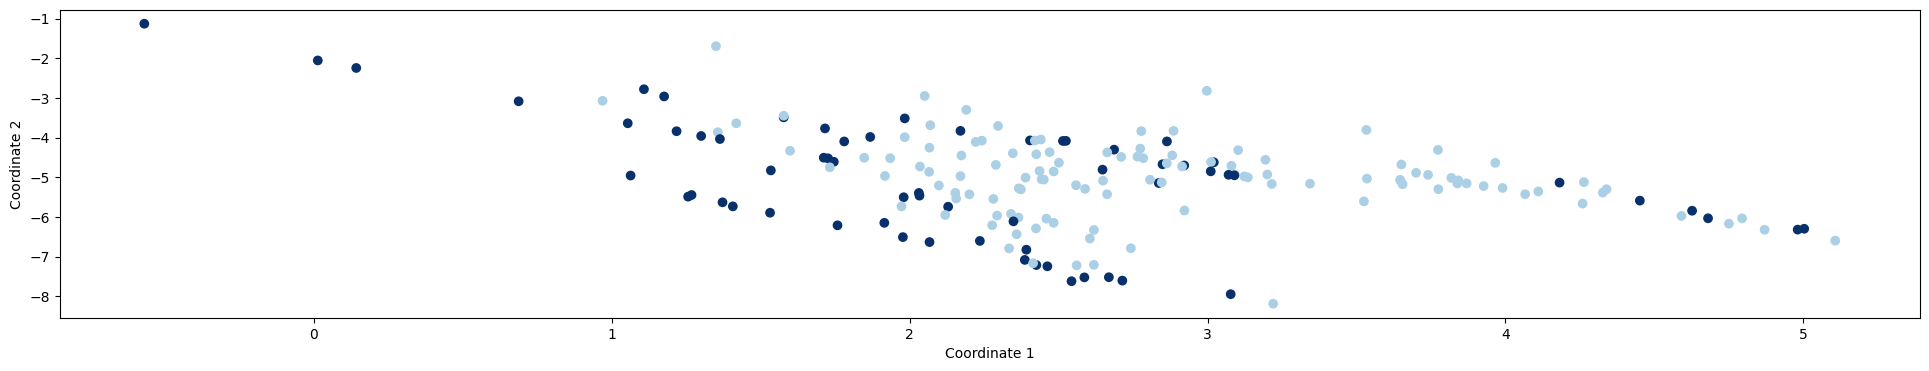

In [279]:
id_to_plot = 10

plt.scatter(coordinates_MDS[match_array == id_to_plot][:,0], coordinates_MDS[match_array == id_to_plot][:,1], c=event_array[match_array == id_to_plot], vmin=-0.5, vmax=1, cmap='Blues')
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.show()

In [286]:
df_cleaned = df.copy()
df_cleaned.drop(["MatchID", "ID", "EventType"], axis=1, inplace=True)
data_array = df_cleaned.to_numpy()
data_array[:,0] = data_array[:,0] / 130 - 0.5
dissimilarity_matrix = np.sqrt(data_array @ data_array.T)
event_array = df["EventType"].to_numpy()
coordinates_PCA = PCA().fit_transform(data_array)

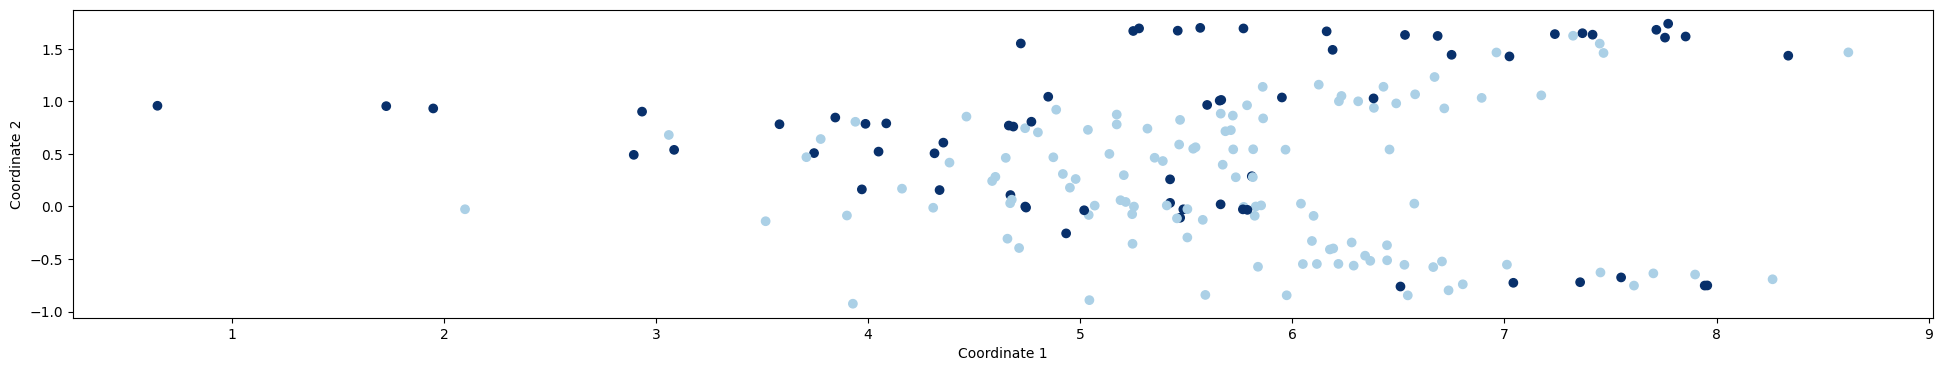

In [278]:
id_to_plot = 10

plt.scatter(coordinates_PCA[match_array == id_to_plot][:,0], coordinates_PCA[match_array == id_to_plot][:,1], c=event_array[match_array == id_to_plot], vmin=-0.5, vmax=1, cmap='Blues')
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.show()

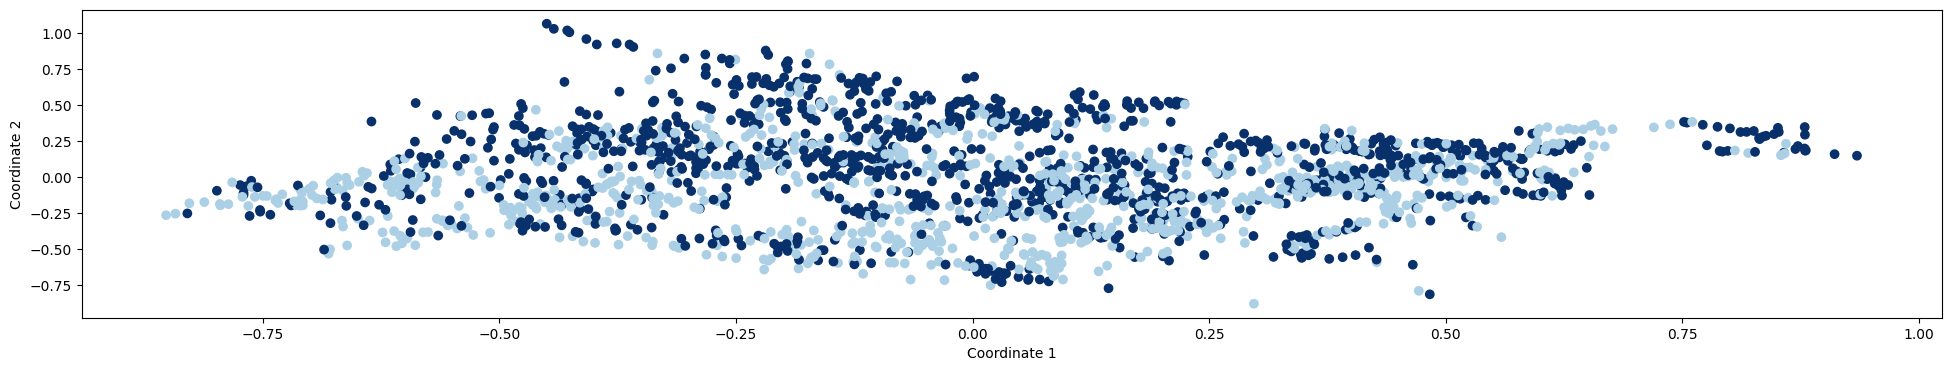

In [287]:
id_to_plot = 10

plt.scatter(coordinates_PCA[:,0], coordinates_PCA[:,1], c=event_array, vmin=-0.5, vmax=1, cmap='Blues')
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.show()

## Separate Train and Test data

In [115]:
# Train on of the first 13 of 16 matches (16*0.8=12.8~=13)
# and the test data would be the last 3 matches. 
# Before submitting on Kaggle we should train on full dataset, so al 16 matches
train_percentage = 0.8
unique_match_ids = df['MatchID'].unique()
print(unique_match_ids)
num_matches_training = int(ceil(len(unique_match_ids)*train_percentage))
print(num_matches_training)

[ 0  1  2  3  4  5  7  8 10 11 12 13 14 17 18 19]
13


In [124]:
# All matches from num_matches_training and after will be in test test
# row_index is then the first row of the matches that will go to the test


row_index = (df['MatchID'] == num_matches_training).idxmax()
#row_index = df[df['MatchID'] == target_match_id].first_valid_index()
df_X_train = df[:row_index].copy()
df_X_test = df[row_index:].copy()


In [125]:
df_y_train = df_X_train['EventType']
df_y_train

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1482    1.0
1483    0.0
1484    0.0
1485    1.0
1486    1.0
Name: EventType, Length: 1487, dtype: float64

In [126]:
df_y_test = df_X_test['EventType']
df_y_test.reset_index(drop=True, inplace=True)
df_y_test

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
645    1.0
646    1.0
647    1.0
648    1.0
649    1.0
Name: EventType, Length: 650, dtype: float64

In [127]:
df_X_train.drop(['EventType'], axis=1, inplace=True)
df_X_train

,MatchID,PeriodID,ID,0,1,2,3,4,5,6,...,190,191,192,193,194,195,196,197,198,199
0,0,0,0_0,0.142700,0.273355,0.024052,-0.100410,-0.056623,0.047082,0.107778,...,-0.095398,-0.058165,0.056072,-0.000830,-0.073885,-0.005746,0.174125,0.093547,-0.009831,0.145556
1,0,1,0_1,0.155795,0.274697,0.022707,-0.114188,-0.078044,0.046390,0.074244,...,-0.094809,-0.053387,0.067755,-0.000557,-0.106459,0.007881,0.165998,0.100027,-0.008115,0.127290
2,0,2,0_2,0.149349,0.291958,0.035742,-0.123525,-0.054195,0.042744,0.082248,...,-0.112641,-0.056553,0.073958,0.001823,-0.102801,0.003312,0.174950,0.081542,-0.008284,0.130799
3,0,3,0_3,0.160484,0.263250,0.003070,-0.158384,-0.055241,0.047692,0.073075,...,-0.122675,-0.047729,0.064131,0.015966,-0.102371,0.001360,0.156838,0.095372,0.014287,0.130726
4,0,4,0_4,0.159678,0.268265,-0.034739,-0.143102,-0.086689,0.054459,0.009802,...,-0.117430,-0.039636,0.030168,0.018995,-0.101448,0.020565,0.149877,0.092729,-0.011608,0.149763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,12,92,12_92,0.145892,0.222630,0.120081,-0.116945,0.024491,0.009698,0.137669,...,-0.224321,-0.143763,0.020284,0.018604,-0.082488,0.076500,0.234800,0.126446,-0.053445,0.130328
1483,12,93,12_93,0.153782,0.227837,0.096260,-0.097191,0.040159,-0.006013,0.112964,...,-0.231501,-0.134865,0.019563,0.001825,-0.100477,0.059753,0.218688,0.120353,-0.046471,0.139495
1484,12,94,12_94,0.132877,0.225982,0.112246,-0.112541,0.027943,0.009418,0.120520,...,-0.215114,-0.125932,0.020598,-0.012168,-0.092944,0.057864,0.243887,0.117850,-0.046737,0.132410
1485,12,95,12_95,0.121008,0.233462,0.137019,-0.118832,0.069999,0.016348,0.101057,...,-0.202068,-0.163163,0.043706,0.024385,-0.094716,0.110365,0.294361,0.131040,-0.043662,0.119831


In [128]:
df_X_test.drop(['EventType'], axis=1, inplace=True)
df_X_test.reset_index(drop=True, inplace=True)
df_X_test

,MatchID,PeriodID,ID,0,1,2,3,4,5,6,...,190,191,192,193,194,195,196,197,198,199
0,13,0,13_0,0.122759,0.217809,0.033307,-0.081587,-0.090911,0.004376,0.115224,...,-0.097398,-0.126960,0.061238,-0.010634,-0.073343,0.062516,0.167249,0.021082,0.089660,0.088117
1,13,1,13_1,0.137794,0.241211,0.032959,-0.080467,-0.093196,0.008602,0.108653,...,-0.097439,-0.122606,0.051559,-0.013713,-0.078115,0.064444,0.165768,0.029060,0.085954,0.088108
2,13,2,13_2,0.146005,0.245907,0.001561,-0.068743,-0.051985,0.006599,0.125866,...,-0.124040,-0.102845,0.055133,0.015766,-0.066953,0.052463,0.126224,0.038286,0.051691,0.116719
3,13,3,13_3,0.140378,0.245704,-0.006743,-0.065213,-0.058203,0.009926,0.117768,...,-0.127208,-0.100219,0.061303,0.022392,-0.068072,0.050457,0.120086,0.027437,0.044498,0.110755
4,13,4,13_4,0.140965,0.249176,0.005743,-0.071034,-0.063098,0.012924,0.122345,...,-0.125824,-0.104658,0.069917,0.022122,-0.067908,0.056947,0.121216,0.018840,0.038354,0.106161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,19,125,19_125,0.041150,0.267610,0.052960,-0.197763,0.104450,0.025712,-0.099700,...,-0.058006,-0.074136,-0.033716,0.011847,-0.041860,0.024191,0.167323,0.122392,-0.054058,0.158443
646,19,126,19_126,0.044753,0.266801,0.058579,-0.202625,0.093912,0.024470,-0.069458,...,-0.050856,-0.076830,-0.019953,0.005234,-0.050930,0.036127,0.161945,0.129341,-0.063787,0.172965
647,19,127,19_127,0.048542,0.271988,0.051762,-0.197929,0.092518,0.020690,-0.068634,...,-0.054085,-0.077008,-0.020153,0.008492,-0.052610,0.036094,0.162711,0.131641,-0.069869,0.174006
648,19,128,19_128,0.051801,0.269485,0.051750,-0.198183,0.088989,0.019420,-0.066234,...,-0.049065,-0.073360,-0.026281,0.006967,-0.056533,0.039534,0.158736,0.124636,-0.077828,0.173008


Now `df_X_train` and `df_X_test` should have columns `MatchID`, `PeriodID`, `tweet_vector`. `tweet_vector` is just 200 columns.

`df_y_train` and `df_y_test` should have 1 column, `EventType`

The match IDs are grouped together so all the rows of the same, and the period IDs are ordered chronologically.

In [101]:
# Now we have df_X_train, df_X_test, df_y_train, df_y_test
# We no longer need df so we should free up the memory
del df  # Remove reference to the original DataFrame
gc.collect()  # Force garbage collection to free up memory

17393

In [102]:
max_periods = df_X_train.groupby('MatchID')['PeriodID'].max().reset_index()
max_periods
# As we can see not every match has the same number of periods!

,MatchID,PeriodID
0,0,129
1,1,129
2,2,129
3,3,129
4,4,169
5,5,129
6,7,129
7,8,129
8,10,179
9,11,129


In [103]:
max_periods = df_X_test.groupby('MatchID')['PeriodID'].max().reset_index()
max_periods

,MatchID,PeriodID
0,13,129
1,14,129
2,17,129
3,18,129
4,19,129


## Format data for PyTorch LSTM

In [27]:
# input tensor for a PyTorch LSTM should have the shape of (when setting batch_first=True)
# (batch_size, seq_len, num_features) when using the batch_first=True parameter
# batch_size is number of sequences processed at once

# TRY WITHOUT SLIDING WINDOW APPROACH
#    which would mean batch size = number of matches
#    much easier to format for LSTM as 3D tensor
#    dimension of 3D tensor with batch_first=True:(batch_size = num_matches, seq_len = num_periods, num _features = 200)
#    (match_id, period_id, num_features=200)
#     not every match has the same number of periods!, so seq_len can vary between different matches
#     fix: pad with zeroes
# we want X_tensor[match_id][period_id] to return list len 200 of corresponding tweet vector


In [91]:
df_y

0      0
1      0
2      0
3      0
4      0
      ..
511    0
512    0
513    0
514    0
515    0
Length: 516, dtype: int64

In [28]:
def convert_df_to_3D_tensor(df_X, df_y):
    # df_X should have columns MatchID, PeriodID, tweet_vector. Tweet_vector is just 200 columns
    # Rows with same matchID should be grouped together (adjacent rows)
    # df_y should have one column (the EventType)
    # Returns tensor_X numpy array already padded! shape: (num_matches, max_num_periods, num _features = 200)
    # and tensor_y of shape: (num_matches, max_num_periods) 
    
    num_matches = len(df_X['MatchID'].unique())
    max_periods = df_X.groupby('MatchID')['PeriodID'].max().reset_index()
    total_max_period = max_periods['PeriodID'].max()
    # total_max_period is max seq len

    tensor_X = np.zeros((num_matches, total_max_period+1, 200))

    tensor_y = np.zeros((num_matches, total_max_period+1))
    print(tensor_X.shape)
    print(tensor_y.shape)
    
    i=0
    previous_match_id = df_X['MatchID'][0]
    for row_index, row in df_X.iterrows():
        match_id = int(row['MatchID'])

        if match_id != previous_match_id:
            i+=1
            previous_match_id = match_id
        
        period_id = int(row['PeriodID'])
        
        features = row[3:].values  # Skip ID, MatchID and PeriodID
        tensor_X[i, period_id, :] = features
        tensor_y[i,period_id] = df_y[row_index]
        
    return tensor_X, tensor_y


X_train_tensor, y_train_tensor = convert_df_to_3D_tensor(df_X_train, df_y_train)
# X_train_tensor[match_id][period_id] to return list len 200 of corresponding tweet vector
# y_train_tensor[match_id][period_id] to return corresponding EventType (1 or 0)
# match_id index starts at 0 even if first match in df doesnt have match id 0

(11, 180, 200)
(11, 180)


In [29]:
# SCALE DATA? minmaxscaler for example!
# SCALING MIGHT BE UNNECESSARY SINCE OUTPUT OF GLOVE TWEET 200 IS ALREADY SCALED BETWEEN -1 AND 1
#scaler = MinMaxScaler()
#tensor = scaler.fit_transform(tensor)

# CONVERT TO PYTORCH TENSOR
X_train_tensor = torch.tensor(X_train_tensor, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.float32)

print(X_train_tensor.shape)
print(y_train_tensor.shape)
# X_train_tensor, y_train_tensor are now pytorch tensors

torch.Size([11, 180, 200])
torch.Size([11, 180])


## LSTM Model

In [30]:
# TODO VERIFY ITS CORRECT + MAKE MORE SOPHISTICATED
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out)
        out = self.sigmoid(out) # Applying sigmoid to convert to probabilities
        return out.squeeze(-1)

#TODOOOOOOOOOO torch.nn.utils.rnn.pack_padded_sequence. This allows the model to ignore the padded values during computation.

## Train model

Epoch [0/400], Loss: 0.6954
Epoch [10/400], Loss: 0.5397
Epoch [20/400], Loss: 0.8403
Epoch [30/400], Loss: 0.5523
Epoch [40/400], Loss: 0.5464
Epoch [50/400], Loss: 0.5301
Epoch [60/400], Loss: 0.5641
Epoch [70/400], Loss: 0.5367
Epoch [80/400], Loss: 0.5373
Epoch [90/400], Loss: 0.5328
Epoch [100/400], Loss: 0.5287
Epoch [110/400], Loss: 0.5247
Epoch [120/400], Loss: 0.5203
Epoch [130/400], Loss: 0.5119
Epoch [140/400], Loss: 0.4951
Epoch [150/400], Loss: 0.4815
Epoch [160/400], Loss: 0.4727
Epoch [170/400], Loss: 0.4637
Epoch [180/400], Loss: 0.4509
Epoch [190/400], Loss: 0.4515
Epoch [200/400], Loss: 0.4338
Epoch [210/400], Loss: 0.4438
Epoch [220/400], Loss: 0.4645
Epoch [230/400], Loss: 0.4328
Epoch [240/400], Loss: 0.4155
Epoch [250/400], Loss: 0.3998
Epoch [260/400], Loss: 0.4027
Epoch [270/400], Loss: 0.3998
Epoch [280/400], Loss: 0.4056
Epoch [290/400], Loss: 0.3891
Epoch [300/400], Loss: 0.3588
Epoch [310/400], Loss: 0.3452
Epoch [320/400], Loss: 0.3413
Epoch [330/400], Loss

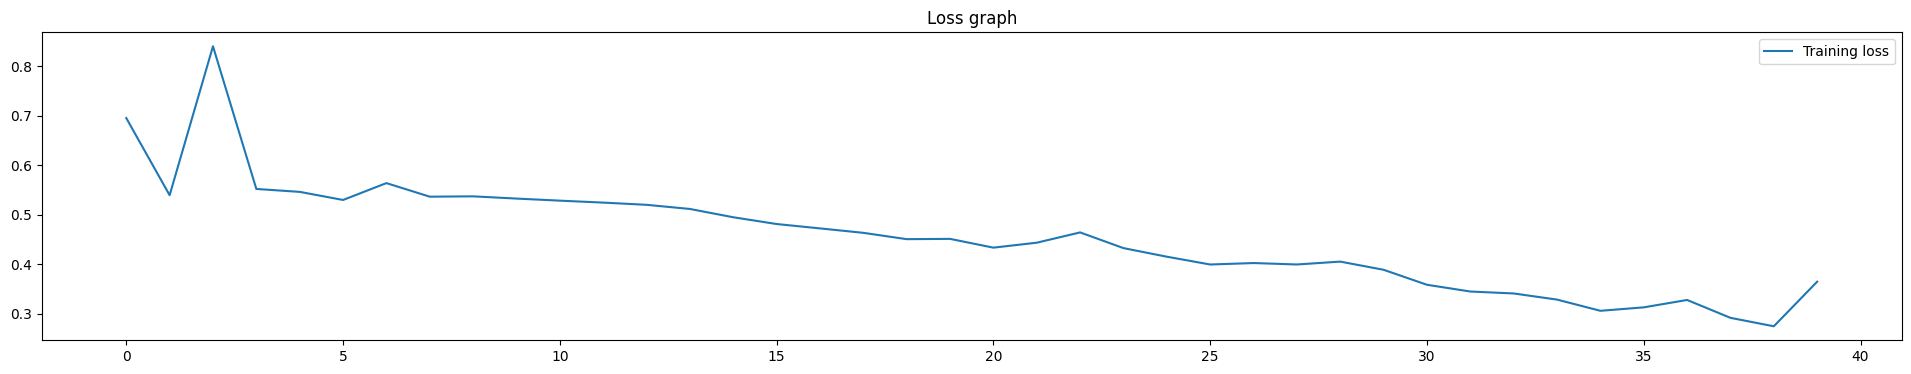

In [58]:
hidden_size = 500 # can tune
num_layers = 4 # can tune
dropout_rate = 0.5 # can tune
num_epochs = 500 # can tune
lr = 0.001 # can tune

model = LSTMModel(input_size=200, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss() # Great for binary classification
# print(f"Shape of X_train_tensor: {X_train_tensor.shape}")

train_loss_list = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    # print(f"shape of outputs: {outputs.shape}")
    
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")
        train_loss_list.append(loss.item())

print("Model is trained! (on training data)")


plt.rc('figure', figsize=(24, 4))
plt.plot(train_loss_list, label='Training loss')
plt.title('Loss graph')
plt.legend()
plt.show()

## Evaluate on test data

In [59]:
# Convert df_X_test and df_y_test to correct format/dimensions
X_test_tensor, y_test_tensor = convert_df_to_3D_tensor(df_X_test, df_y_test)
# CONVERT TO PYTORCH TENSOR
X_test_tensor = torch.tensor(X_test_tensor, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_tensor, dtype=torch.float32)

(5, 130, 200)
(5, 130)


In [60]:
model.eval()

with torch.no_grad():
    predictions = model(X_test_tensor)

# Predictions have values between 0 and 1 because forward pass of LSTM contains sigmoid at output
#print(predictions)

# This converts to same dimensional array of True or false, and .float() converts True to 1 and False to 0
predicted_classes = (predictions > 0.5).float() # 0.5 is threshold
 

In [61]:
# Performance metrics

loss = criterion(predictions, y_test_tensor) # use predictions for loss calculation

print(f"Binary Cross-Entropy Loss: {loss.item():.4f}")

def compute_accuracy(y_true, y_pred):
    if y_true.dtype != y_pred.dtype or y_true.shape != y_pred.shape:
        raise ValueError(f"Inputs do not have same type or shape!")
    correct_predictions = (y_true == y_pred).sum().item()
    total_predictions = y_true.numel()
    accuracy = correct_predictions / total_predictions * 100
    return accuracy
accuracy = compute_accuracy(y_test_tensor, predicted_classes)


print(f"Accuracy: {accuracy:.4f}")

#print(y_test_tensor.shape)
#print(predicted_classes.shape)


# Visualization of Actual vs Predicted Classes
# import matplotlib.pyplot as plt
# TODO COULD USE PLT TO VISUALIZE?

Binary Cross-Entropy Loss: 0.7717
Accuracy: 66.3077


## Hyperparameters tuning

Testing dropout = 0.1, Loss = 0.7045, Accuracy = 53.0769
Testing dropout = 0.2, Loss = 0.9856, Accuracy = 65.3846
Testing dropout = 0.3, Loss = 0.7943, Accuracy = 66.4615
Testing dropout = 0.4, Loss = 0.9223, Accuracy = 60.9231
Testing dropout = 0.5, Loss = 0.9118, Accuracy = 68.0000
Testing dropout = 0.6, Loss = 0.6319, Accuracy = 67.2308
Testing dropout = 0.7, Loss = 0.6930, Accuracy = 68.6154
Testing dropout = 0.8, Loss = 0.7073, Accuracy = 59.3846
Testing dropout = 0.9, Loss = 1.0375, Accuracy = 58.3077


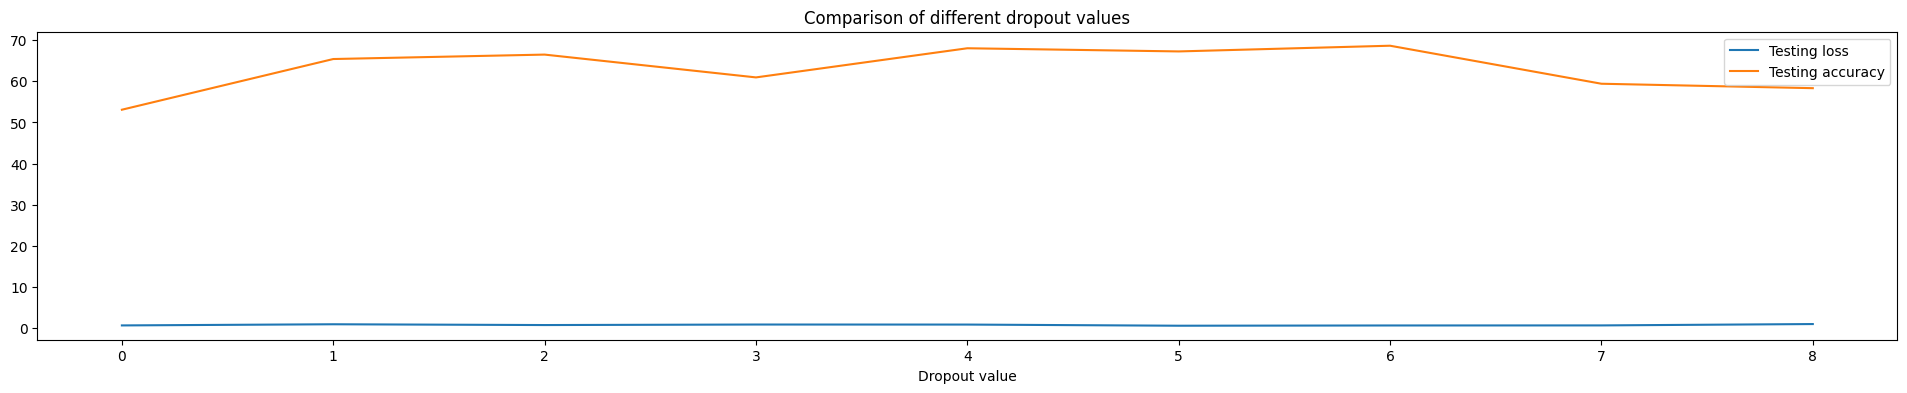

In [64]:
hidden_size = 500 # can tune
num_layers = 4 # can tune
num_epochs = 400 # can tune
lr = 0.001 # can tune

bceLoss_list, accuracy_list = [], []

dropout_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for i in range(len(dropout_values)):
    model = LSTMModel(input_size=200, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_values[i])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()

    with torch.no_grad():
        predictions = model(X_test_tensor)

    predicted_classes = (predictions > 0.5).float()
    loss = criterion(predictions, y_test_tensor)
    accuracy = compute_accuracy(y_test_tensor, predicted_classes)
    bceLoss_list.append(loss)
    accuracy_list.append(accuracy)
    print(f"Testing dropout = {dropout_values[i]}, Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
    
plt.plot(bceLoss_list, label='Testing loss')
plt.plot(accuracy_list, label='Testing accuracy')
plt.xlabel("Dropout value")
plt.title('Comparison of different dropout values')
plt.legend()
plt.show()

Testing hidden size = 450, Loss = 0.6639, Accuracy = 68.3077
Testing hidden size = 500, Loss = 0.9600, Accuracy = 61.0769
Testing hidden size = 550, Loss = 0.6885, Accuracy = 63.8462
Testing hidden size = 600, Loss = 0.6169, Accuracy = 70.1538
Testing hidden size = 650, Loss = 1.7627, Accuracy = 60.7692
Testing hidden size = 700, Loss = 0.8690, Accuracy = 68.1538
Testing hidden size = 750, Loss = 0.7734, Accuracy = 65.5385
Testing hidden size = 800, Loss = 0.6026, Accuracy = 70.7692
Testing hidden size = 850, Loss = 1.1173, Accuracy = 64.1538
Testing hidden size = 900, Loss = 1.2094, Accuracy = 60.6154


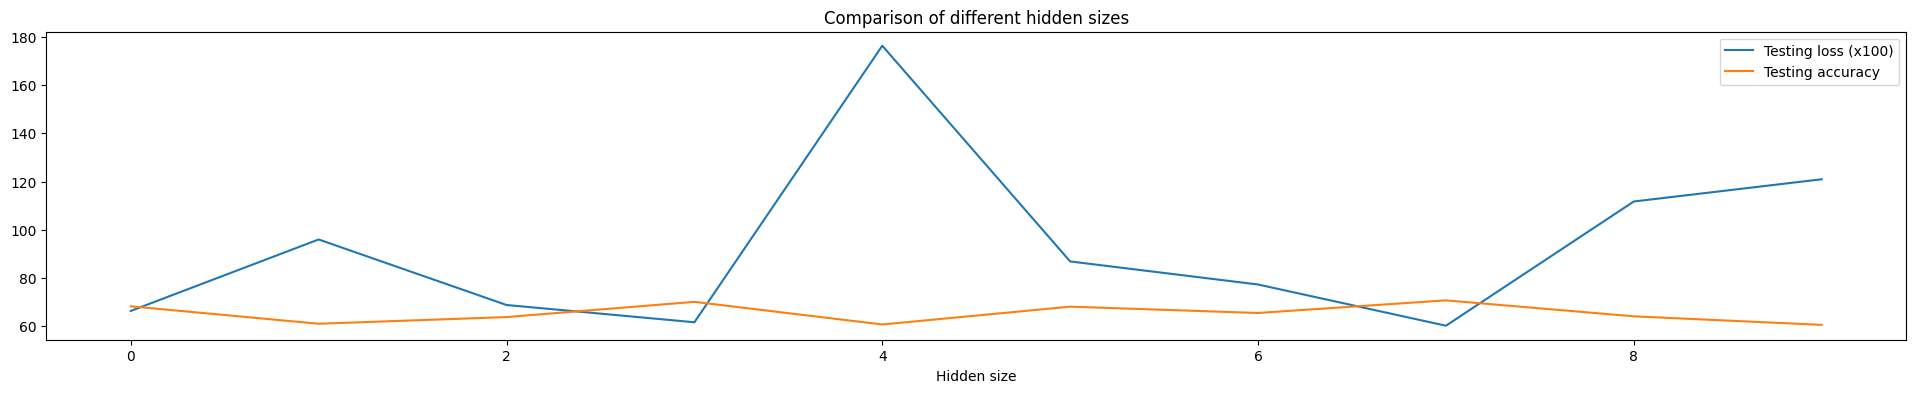

In [66]:
num_layers = 4 # can tune
dropout_rate = 0.7
num_epochs = 400 # can tune
lr = 0.001 # can tune

bceLoss_list, accuracy_list = [], []

hidden_size_list = [450, 500, 550, 600, 650, 700, 750, 800, 850, 900]

for i in range(len(hidden_size_list)):
    model = LSTMModel(input_size=200, hidden_size=hidden_size_list[i], num_layers=num_layers, dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()

    with torch.no_grad():
        predictions = model(X_test_tensor)

    predicted_classes = (predictions > 0.5).float()
    loss = criterion(predictions, y_test_tensor)
    accuracy = compute_accuracy(y_test_tensor, predicted_classes)
    bceLoss_list.append(loss * 100)
    accuracy_list.append(accuracy)
    print(f"Testing hidden size = {hidden_size_list[i]}, Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
    
plt.plot(bceLoss_list, label='Testing loss (x100)')
plt.plot(accuracy_list, label='Testing accuracy')
plt.xlabel("Hidden size")
plt.title('Comparison of different hidden sizes')
plt.legend()
plt.show()

Testing number of layers = 2, Loss = 0.7694, Accuracy = 67.2308
Testing number of layers = 3, Loss = 0.6928, Accuracy = 69.6923
Testing number of layers = 4, Loss = 0.7095, Accuracy = 67.2308
Testing number of layers = 5, Loss = 0.9121, Accuracy = 66.6154
Testing number of layers = 6, Loss = 0.6622, Accuracy = 70.1538
Testing number of layers = 7, Loss = 0.6534, Accuracy = 64.3077


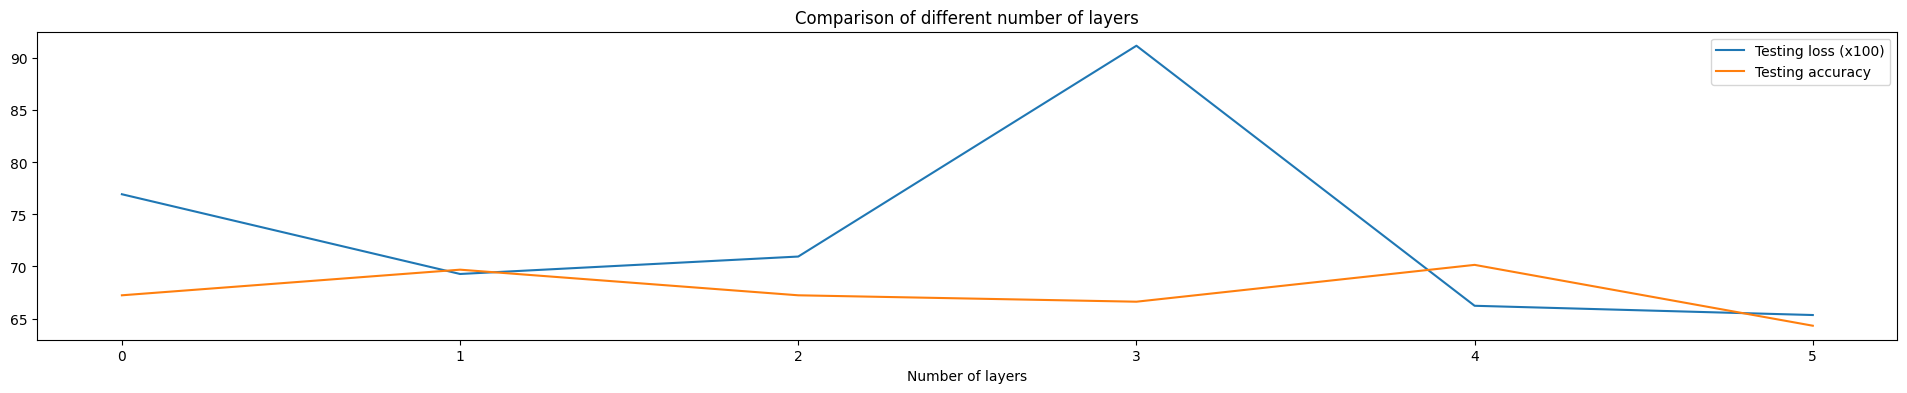

In [67]:
hidden_size = 800
dropout_rate = 0.7
num_epochs = 400 # can tune
lr = 0.001 # can tune

bceLoss_list, accuracy_list = [], []

num_layers_list = [2, 3, 4, 5, 6, 7]

for i in range(len(num_layers_list)):
    model = LSTMModel(input_size=200, hidden_size=hidden_size, num_layers=num_layers_list[i], dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()

    with torch.no_grad():
        predictions = model(X_test_tensor)

    predicted_classes = (predictions > 0.5).float()
    loss = criterion(predictions, y_test_tensor)
    accuracy = compute_accuracy(y_test_tensor, predicted_classes)
    bceLoss_list.append(loss * 100)
    accuracy_list.append(accuracy)
    print(f"Testing number of layers = {num_layers_list[i]}, Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
    
plt.plot(bceLoss_list, label='Testing loss (x100)')
plt.plot(accuracy_list, label='Testing accuracy')
plt.xlabel("Number of layers")
plt.title('Comparison of different number of layers')
plt.legend()
plt.show()

Testing learning rate = 0.0002, Loss = 1.1050, Accuracy = 54.7692
Testing learning rate = 0.0005, Loss = 1.2941, Accuracy = 64.4615
Testing learning rate = 0.001, Loss = 0.9510, Accuracy = 67.3846
Testing learning rate = 0.002, Loss = 0.6537, Accuracy = 64.1538
Testing learning rate = 0.005, Loss = 0.7278, Accuracy = 44.7692


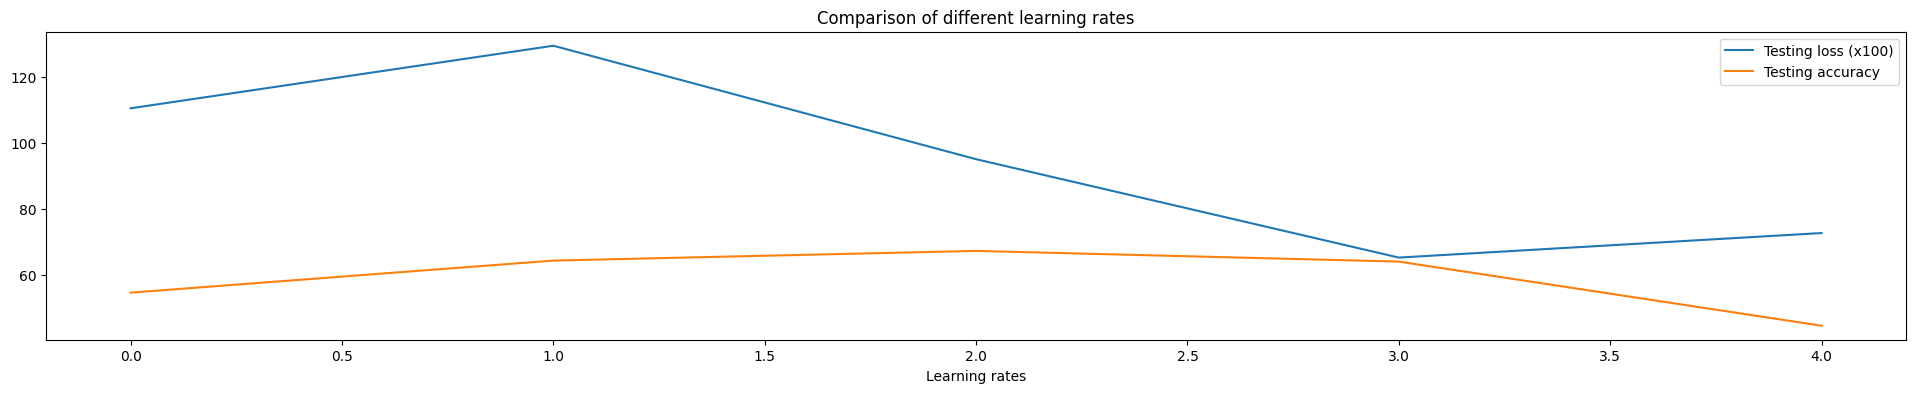

In [68]:
hidden_size = 800
num_layers = 6
dropout_rate = 0.7
num_epochs = 400 # can tune

bceLoss_list, accuracy_list = [], []

lr_list = [0.0002, 0.0005, 0.001, 0.002, 0.005]

for i in range(len(lr_list)):
    model = LSTMModel(input_size=200, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr_list[i])
    criterion = nn.BCELoss()
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()

    with torch.no_grad():
        predictions = model(X_test_tensor)

    predicted_classes = (predictions > 0.5).float()
    loss = criterion(predictions, y_test_tensor)
    accuracy = compute_accuracy(y_test_tensor, predicted_classes)
    bceLoss_list.append(loss * 100)
    accuracy_list.append(accuracy)
    print(f"Testing learning rate = {lr_list[i]}, Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
    
plt.plot(bceLoss_list, label='Testing loss (x100)')
plt.plot(accuracy_list, label='Testing accuracy')
plt.xlabel("Learning rates")
plt.title('Comparison of different learning rates')
plt.legend()
plt.show()

In [69]:
hidden_size = 800
num_layers = 6
dropout_rate = 0.7
num_epochs = 500
lr = 0.001

## Decision Tree, Tree Bagging & Random Forest models

In [129]:
def convert_df_to_2D_np_array(df_X, df_y):
    df_X_noID = df_X.copy()
    df_X_noID.drop(['MatchID', 'ID'], axis=1, inplace=True)
    X_train = df_X_noID.to_numpy()
    y_train = df_y.to_numpy()
    return X_train, y_train

In [138]:
X_train_2D, y_train_2D = convert_df_to_2D_np_array(df_X_train, df_y_train)
X_test_2D, y_test_2D = convert_df_to_2D_np_array(df_X_test, df_y_test)
print(X_train_2D.shape)
print(y_train_2D.shape)
print(X_test_2D.shape)
print(y_test_2D.shape)

(1487, 201)
(1487,)
(650, 201)
(650,)


In [183]:
nb_cross_validation = 5

DT_model = DecisionTreeClassifier(random_state=0)
p_grid_DT = {'min_samples_split': [15, 20, 25, 30], 'min_samples_leaf': [2, 4, 6, 8, 10] }

grid_DT = GridSearchCV(estimator=DT_model, param_grid=p_grid_DT, scoring='accuracy', cv=nb_cross_validation)
grid_DT.fit(X_train_2D, y_train_2D)

print("Cross validation done on Decision Tree!")
print("Best accuracy: {}".format(grid_DT.best_score_))
print("Best params: {}".format(grid_DT.best_params_))

Cross validation done on Decision Tree!
Best accuracy: 0.5992090931688248
Best params: {'min_samples_leaf': 6, 'min_samples_split': 20}


In [184]:
best_params = grid_DT.best_params_

DT_model = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)
DT_model.fit(X_train_2D, y_train_2D)
y_test_predict = DT_model.predict(X_test_2D)
accuracy = (np.sum(y_test_predict == y_test_2D) / y_test_predict.size)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4738


In [189]:
p_grid_bagging = {'n_estimators': [12, 14, 16, 18, 20]}   
Bagging_model = BaggingClassifier(estimator=DT_model, random_state=0)
grid_bagging = GridSearchCV(estimator=Bagging_model, param_grid=p_grid_bagging, scoring="accuracy", cv=nb_cross_validation)
grid_bagging.fit(X_train_2D, y_train_2D)

print("Cross validation done on Tree Bagging!")
print("Best accuracy: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))

Cross validation done on Tree Bagging!
Best accuracy: 0.6496101959189209
Best params: {'n_estimators': 14}


In [190]:
best_params = grid_bagging.best_params_

Bagging_model = BaggingClassifier(estimator=DT_model, n_estimators=best_params["n_estimators"], random_state=0)
Bagging_model.fit(X_train_2D, y_train_2D)
y_test_predict = Bagging_model.predict(X_test_2D)
accuracy = (np.sum(y_test_predict == y_test_2D) / y_test_predict.size)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5785


In [179]:
nb_cross_validation = 5

RF_model = RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10, 15, 20, 25, 30, 35, 40, 45, 50], 'min_samples_leaf': [2, 3, 4, 5], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF_model, param_grid=p_grid_RF, scoring='accuracy', cv=nb_cross_validation)
grid_RF.fit(X_train_2D, y_train_2D)

print("Cross validation done on Random Forest!")
print("Best accuracy: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

Cross validation done on Random Forest!
Best accuracy: 0.6415158294352925
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 40}


In [180]:
best_params = grid_RF.best_params_

RF_model = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF_model.fit(X_train_2D, y_train_2D)
y_test_predict = RF_model.predict(X_test_2D)
accuracy = (np.sum(y_test_predict == y_test_2D) / y_test_predict.size)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6692


## Test with XGBR and LGBMR

In [193]:
n_estimators_list = [10, 20, 50, 100, 200]
max_depth_list = [1, 2, 3]
learning_rate_list = [0.05, 0.1, 0.15, 0.2, 0.3]

best_params = [0, 0]
best_accuracy = 0

for n_estimator in n_estimators_list:
    for max_depth in max_depth_list:
        for learning_rate in learning_rate_list:
            xgbr = XGBRegressor(n_estimators=n_estimator, max_depth=max_depth, learning_rate=learning_rate).fit(X_train_2D, y_train_2D)
            y_test_predict = (xgbr.predict(X_test_2D) > 0.5)
            y_train_predict = (xgbr.predict(X_train_2D) > 0.5)
            accuracy = (np.sum(y_test_predict == y_test_2D) / y_test_predict.size)
            train_accuracy = (np.sum(y_train_predict == y_train_2D) / y_train_predict.size)
            print(f"Nb estimators: {n_estimator} Max depth: {max_depth} Learning rate: {learning_rate}")
            if (accuracy > best_accuracy):
                best_accuracy = accuracy
                best_params = [n_estimator, max_depth, learning_rate]

print("")
print(f"Best accuracy on testing set: {best_accuracy:.4f}")
print(f"Best parameters:\nNb estimators: {best_params[0]} Max depth: {best_params[1]} Learning rate: {best_params[2]}")

Nb estimators: 10 Max depth: 1 Learning rate: 0.05
Nb estimators: 10 Max depth: 1 Learning rate: 0.1
Nb estimators: 10 Max depth: 1 Learning rate: 0.15
Nb estimators: 10 Max depth: 1 Learning rate: 0.2
Nb estimators: 10 Max depth: 1 Learning rate: 0.3
Nb estimators: 10 Max depth: 2 Learning rate: 0.05
Nb estimators: 10 Max depth: 2 Learning rate: 0.1
Nb estimators: 10 Max depth: 2 Learning rate: 0.15
Nb estimators: 10 Max depth: 2 Learning rate: 0.2
Nb estimators: 10 Max depth: 2 Learning rate: 0.3
Nb estimators: 10 Max depth: 3 Learning rate: 0.05
Nb estimators: 10 Max depth: 3 Learning rate: 0.1
Nb estimators: 10 Max depth: 3 Learning rate: 0.15
Nb estimators: 10 Max depth: 3 Learning rate: 0.2
Nb estimators: 10 Max depth: 3 Learning rate: 0.3
Nb estimators: 20 Max depth: 1 Learning rate: 0.05
Nb estimators: 20 Max depth: 1 Learning rate: 0.1
Nb estimators: 20 Max depth: 1 Learning rate: 0.15
Nb estimators: 20 Max depth: 1 Learning rate: 0.2
Nb estimators: 20 Max depth: 1 Learning ra

In [ ]:
n_estimators_list = [100, 200, 300, 400, 500]
max_depth_list = [1, 2, 3, 4, 5]
learning_rate_list = [0.01, 0.05, 0.1, 0.15]

best_params = [0, 0]
best_accuracy = 0

for n_estimator in n_estimators_list:
    for max_depth in max_depth_list:
        for learning_rate in learning_rate_list:
            lgbmr = LGBMRegressor(n_estimators=n_estimator, max_depth=max_depth, learning_rate=learning_rate).fit(X_train_2D, y_train_2D)
            y_test_predict = (lgbmr.predict(X_test_2D) > 0.5)
            y_train_predict = (lgbmr.predict(X_train_2D) > 0.5)
            accuracy = (np.sum(y_test_predict == y_test_2D) / y_test_predict.size)
            train_accuracy = (np.sum(y_train_predict == y_train_2D) / y_train_predict.size)
            print(f"Nb estimators: {n_estimator} Max depth: {max_depth} Learning rate: {learning_rate}")
            if (accuracy > best_accuracy):
                best_accuracy = accuracy
                best_params = [n_estimator, max_depth, learning_rate]

print("")
print(f"Best accuracy on testing set: {best_accuracy:.4f}")
print(f"Best parameters:\nNb estimators: {best_params[0]} Max depth: {best_params[1]} Learning rate: {best_params[2]}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51154
[LightGBM] [Info] Number of data points in the train set: 1487, number of used features: 201
[LightGBM] [Info] Start training from score 0.533961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

## Testing on KNN

In [312]:
X_train_2D_normalized = normalize(X_train_2D, axis=1, norm='l2')
X_test_2D_normalized = normalize(X_test_2D, axis=1, norm='l2')

In [313]:
n_neighbors_list = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

best_accuracy = 0
best_n_neighbors = 0

for n_neighbors in n_neighbors_list:
    knn_model = KNeighborsClassifier(n_neighbors = n_neighbors).fit(X_train_2D_normalized, y_train_2D)
    y_test_predict = knn_model.predict(X_test_2D_normalized)
    y_train_predict = knn_model.predict(X_train_2D_normalized)
    accuracy = (np.sum(y_test_predict == y_test_2D) / y_test_predict.size)
    train_accuracy = (np.sum(y_train_predict == y_train_2D) / y_train_predict.size)
    print(f"Training with {n_neighbors} nn. Accuracy on training set: {train_accuracy:.4f} Accuracy on testing set: {accuracy:.4f}")
    if (best_accuracy < accuracy):
        best_accuracy = accuracy
        best_n_neighbors = n_neighbors

print(f"Best results with {best_n_neighbors} nn! Accuracy on testing set: {best_accuracy:.4f}")

Training with 3 nn. Accuracy on training set: 0.8796 Accuracy on testing set: 0.6108
Training with 4 nn. Accuracy on training set: 0.8467 Accuracy on testing set: 0.6000
Training with 5 nn. Accuracy on training set: 0.8473 Accuracy on testing set: 0.6138
Training with 6 nn. Accuracy on training set: 0.8225 Accuracy on testing set: 0.6308
Training with 7 nn. Accuracy on training set: 0.8231 Accuracy on testing set: 0.6415
Training with 8 nn. Accuracy on training set: 0.7902 Accuracy on testing set: 0.6308
Training with 9 nn. Accuracy on training set: 0.7949 Accuracy on testing set: 0.6477
Training with 10 nn. Accuracy on training set: 0.7781 Accuracy on testing set: 0.6446
Training with 11 nn. Accuracy on training set: 0.7808 Accuracy on testing set: 0.6477
Training with 12 nn. Accuracy on training set: 0.7640 Accuracy on testing set: 0.6723
Training with 13 nn. Accuracy on training set: 0.7592 Accuracy on testing set: 0.6723
Training with 14 nn. Accuracy on training set: 0.7458 Accurac

In [321]:
X_train_PCA.shape

(1487, 1487)

In [319]:
X_test_2D_normalized.shape

(650, 201)

In [324]:
df_cleaned = df.copy()
df_cleaned.drop(["MatchID", "ID", "EventType"], axis=1, inplace=True)
data_array = df_cleaned.to_numpy()
X_train_2D_similarity = np.sqrt(X_train_2D_normalized @ X_train_2D_normalized.T)
X_test_2D_similarity = np.sqrt(X_test_2D_normalized @ X_test_2D_normalized.T)
X_train_PCA = PCA().fit_transform(X_train_2D_similarity)
X_test_PCA = PCA().fit_transform(X_test_2D_similarity)

n_neighbors_list = [3, 4, 5, 6, 7, 8, 9, 10]
number_components_list = [30, 40, 50, 75, 100, 150, 201]

best_accuracy = 0
best_n_neighbors = 0
best_number_components = 0

for n_neighbors in n_neighbors_list:
    for number_components in number_components_list:
        knn_model = KNeighborsClassifier(n_neighbors = n_neighbors).fit(X_train_PCA[:,:number_components], y_train_2D)
        y_test_predict = knn_model.predict(X_test_PCA[:,:number_components])
        y_train_predict = knn_model.predict(X_train_PCA[:,:number_components])
        accuracy = (np.sum(y_test_predict == y_test_2D) / y_test_predict.size)
        train_accuracy = (np.sum(y_train_predict == y_train_2D) / y_train_predict.size)
        print(f"Training with {n_neighbors} nn and {number_components} components. Accuracy on training set: {train_accuracy:.4f} Accuracy on testing set: {accuracy:.4f}")
        if (best_accuracy < accuracy):
            best_accuracy = accuracy
            best_n_neighbors = n_neighbors
            best_number_components = number_components

print(f"Best results with {best_n_neighbors} nn and {best_number_components} components! Accuracy on testing set: {best_accuracy:.4f}")

Training with 3 nn and 30 components. Accuracy on training set: 0.8299 Accuracy on testing set: 0.5292
Training with 3 nn and 40 components. Accuracy on training set: 0.8299 Accuracy on testing set: 0.5277
Training with 3 nn and 50 components. Accuracy on training set: 0.8299 Accuracy on testing set: 0.5277
Training with 3 nn and 75 components. Accuracy on training set: 0.8299 Accuracy on testing set: 0.5277
Training with 3 nn and 100 components. Accuracy on training set: 0.8299 Accuracy on testing set: 0.5277
Training with 3 nn and 150 components. Accuracy on training set: 0.8299 Accuracy on testing set: 0.5277
Training with 3 nn and 201 components. Accuracy on training set: 0.8299 Accuracy on testing set: 0.5277
Training with 4 nn and 30 components. Accuracy on training set: 0.7613 Accuracy on testing set: 0.5462
Training with 4 nn and 40 components. Accuracy on training set: 0.7613 Accuracy on testing set: 0.5462
Training with 4 nn and 50 components. Accuracy on training set: 0.7613

# Application of the model (Kaggle submission)

## Retrain the model on the entire data

In [70]:
# RETRAIN MODEL ON ENTIRE TRAINING DATA AND EVALUATE EVAL TWEETS

df_X = pd.concat([df_X_train, df_X_test], ignore_index=True)
df_y = pd.concat([df_y_train, df_y_test], ignore_index=True)
print(df_X['MatchID'].unique())
print(df_X.shape)
print(df_y.shape)


[ 0  1  2  3  4  5  7  8 10 11 12 13 14 17 18 19]
(2137, 203)
(2137,)


In [71]:
df_X

,MatchID,PeriodID,ID,0,1,2,3,4,5,6,...,190,191,192,193,194,195,196,197,198,199
0,0,0,0_0,0.142700,0.273355,0.024052,-0.100410,-0.056623,0.047082,0.107778,...,-0.095398,-0.058165,0.056072,-0.000830,-0.073885,-0.005746,0.174125,0.093547,-0.009831,0.145556
1,0,1,0_1,0.155795,0.274697,0.022707,-0.114188,-0.078044,0.046390,0.074244,...,-0.094809,-0.053387,0.067755,-0.000557,-0.106459,0.007881,0.165998,0.100027,-0.008115,0.127290
2,0,2,0_2,0.149349,0.291958,0.035742,-0.123525,-0.054195,0.042744,0.082248,...,-0.112641,-0.056553,0.073958,0.001823,-0.102801,0.003312,0.174950,0.081542,-0.008284,0.130799
3,0,3,0_3,0.160484,0.263250,0.003070,-0.158384,-0.055241,0.047692,0.073075,...,-0.122675,-0.047729,0.064131,0.015966,-0.102371,0.001360,0.156838,0.095372,0.014287,0.130726
4,0,4,0_4,0.159678,0.268265,-0.034739,-0.143102,-0.086689,0.054459,0.009802,...,-0.117430,-0.039636,0.030168,0.018995,-0.101448,0.020565,0.149877,0.092729,-0.011608,0.149763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,19,125,19_125,0.041150,0.267610,0.052960,-0.197763,0.104450,0.025712,-0.099700,...,-0.058006,-0.074136,-0.033716,0.011847,-0.041860,0.024191,0.167323,0.122392,-0.054058,0.158443
2133,19,126,19_126,0.044753,0.266801,0.058579,-0.202625,0.093912,0.024470,-0.069458,...,-0.050856,-0.076830,-0.019953,0.005234,-0.050930,0.036127,0.161945,0.129341,-0.063787,0.172965
2134,19,127,19_127,0.048542,0.271988,0.051762,-0.197929,0.092518,0.020690,-0.068634,...,-0.054085,-0.077008,-0.020153,0.008492,-0.052610,0.036094,0.162711,0.131641,-0.069869,0.174006
2135,19,128,19_128,0.051801,0.269485,0.051750,-0.198183,0.088989,0.019420,-0.066234,...,-0.049065,-0.073360,-0.026281,0.006967,-0.056533,0.039534,0.158736,0.124636,-0.077828,0.173008


In [72]:
df_y

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2132    1.0
2133    1.0
2134    1.0
2135    1.0
2136    1.0
Name: EventType, Length: 2137, dtype: float64

In [73]:
# Convert df_X_test and df_y_test to correct format/dimensions
X_tensor, y_tensor = convert_df_to_3D_tensor(df_X, df_y)
# CONVERT TO PYTORCH TENSOR
X_tensor = torch.tensor(X_tensor, dtype=torch.float32)
y_tensor = torch.tensor(y_tensor, dtype=torch.float32)

(16, 180, 200)
(16, 180)


In [74]:
# Retrain model on all 16 matches (with same hyper parameters)
model = LSTMModel(input_size=200, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss() # Great for binary classification

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_tensor)
    
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")

print("Model is trained! (on all 16 matches)")

Epoch [0/500], Loss: 0.6953
Epoch [10/500], Loss: 0.6702
Epoch [20/500], Loss: 0.5610
Epoch [30/500], Loss: 0.5236
Epoch [40/500], Loss: 0.5248
Epoch [50/500], Loss: 0.5255
Epoch [60/500], Loss: 0.5192
Epoch [70/500], Loss: 0.5153
Epoch [80/500], Loss: 0.5894
Epoch [90/500], Loss: 0.5194
Epoch [100/500], Loss: 0.5149
Epoch [110/500], Loss: 0.5125
Epoch [120/500], Loss: 0.4952
Epoch [130/500], Loss: 0.6711
Epoch [140/500], Loss: 0.5207
Epoch [150/500], Loss: 0.5159
Epoch [160/500], Loss: 0.5337
Epoch [170/500], Loss: 0.5201
Epoch [180/500], Loss: 0.5118
Epoch [190/500], Loss: 0.5062
Epoch [200/500], Loss: 0.5061
Epoch [210/500], Loss: 0.5094
Epoch [220/500], Loss: 0.4957
Epoch [230/500], Loss: 0.5109
Epoch [240/500], Loss: 0.6043
Epoch [250/500], Loss: 0.5097
Epoch [260/500], Loss: 0.5033
Epoch [270/500], Loss: 0.4974
Epoch [280/500], Loss: 0.4826
Epoch [290/500], Loss: 0.4659
Epoch [300/500], Loss: 0.4572
Epoch [310/500], Loss: 0.4428
Epoch [320/500], Loss: 0.4316
Epoch [330/500], Loss

## Model prediction on the evaluation set

In [75]:
df_eval = pd.read_feather("processed_data/eval_tweets_processed.feather")
df_eval

,MatchID,PeriodID,ID,0,1,2,3,4,5,6,...,190,191,192,193,194,195,196,197,198,199
0,6,0,6_0,0.158896,0.264814,0.057981,-0.102842,0.061002,0.023203,0.131890,...,-0.184701,-0.101496,0.081690,-0.004283,-0.057534,0.006105,0.171110,0.025386,-0.039204,0.189157
1,6,1,6_1,0.156288,0.271375,0.059343,-0.108422,0.052298,0.019057,0.119804,...,-0.193451,-0.098110,0.085782,-0.014780,-0.065975,0.008123,0.176577,0.028697,-0.037489,0.189704
2,6,2,6_2,0.145923,0.240633,0.057680,-0.104799,0.108712,0.009395,0.081510,...,-0.200057,-0.118543,0.082504,-0.064201,-0.029714,0.073884,0.186111,0.105346,-0.022998,0.202353
3,6,3,6_3,0.160460,0.285798,0.063682,-0.104289,0.061716,0.016656,0.126485,...,-0.188633,-0.087426,0.102778,-0.018449,-0.064665,0.006555,0.178324,0.028487,-0.038289,0.191645
4,6,4,6_4,0.159856,0.281828,0.073446,-0.112441,0.063491,0.021445,0.110178,...,-0.178722,-0.094382,0.093599,-0.025704,-0.076860,0.015346,0.189978,0.027995,-0.040230,0.188706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,16,125,16_125,0.090554,0.227452,0.107798,-0.111091,0.034236,0.063783,0.053129,...,-0.198507,-0.122853,0.024147,0.000304,-0.161041,0.092954,0.143728,0.113752,-0.049263,0.056543
512,16,126,16_126,0.086859,0.236306,0.107814,-0.125368,0.026619,0.063352,0.062930,...,-0.189677,-0.125140,0.027448,0.003508,-0.144993,0.096095,0.155616,0.101075,-0.042474,0.058476
513,16,127,16_127,0.096795,0.220505,0.109566,-0.119462,0.023341,0.063660,0.084856,...,-0.180416,-0.117967,0.033671,0.007132,-0.137807,0.088667,0.160295,0.102587,-0.045250,0.052347
514,16,128,16_128,0.090397,0.227700,0.104989,-0.123692,0.035497,0.059867,0.049117,...,-0.188227,-0.115212,0.019899,0.006688,-0.167376,0.096072,0.149536,0.122288,-0.047816,0.063510


In [76]:
# NO EVENTTYPE, CAN ONLY MAKE PREDICTIONS WITHOUT KNOWING ACCURACY

# There is no df_y when we are trying to evaluate the matches in eval_tweets
# for kaggle submission!!
# Let df_y have all zeros with the same number of rows as df_X
# This is just to make code run more easily, df_y
#     and tensor_y (value returned by convert_df_to_3D_tensor) will not be used

# df_y has no real meaning, only for ease of coding!
df_y = pd.Series(0, index=df_eval.index)
df_y


0      0
1      0
2      0
3      0
4      0
      ..
511    0
512    0
513    0
514    0
515    0
Length: 516, dtype: int64

In [77]:
X_eval_tensor, _ = convert_df_to_3D_tensor(df_eval, df_y)
# CONVERT TO PYTORCH TENSOR
X_eval_tensor = torch.tensor(X_eval_tensor, dtype=torch.float32)
X_eval_tensor

(4, 130, 200)
(4, 130)


tensor([[[ 0.1589,  0.2648,  0.0580,  ...,  0.0254, -0.0392,  0.1892],
         [ 0.1563,  0.2714,  0.0593,  ...,  0.0287, -0.0375,  0.1897],
         [ 0.1459,  0.2406,  0.0577,  ...,  0.1053, -0.0230,  0.2024],
         ...,
         [ 0.1209,  0.2895,  0.1666,  ...,  0.1049, -0.0291,  0.0956],
         [ 0.1459,  0.2925,  0.1178,  ...,  0.0700, -0.0339,  0.1269],
         [ 0.1424,  0.2870,  0.1126,  ...,  0.0668, -0.0390,  0.1218]],

        [[ 0.0159,  0.1494,  0.1740,  ...,  0.0662,  0.0571,  0.0319],
         [-0.0012,  0.1338,  0.1826,  ...,  0.0573,  0.0487,  0.0290],
         [ 0.0076,  0.1246,  0.2063,  ...,  0.0507,  0.0662,  0.0145],
         ...,
         [ 0.0140,  0.0887,  0.1781,  ...,  0.0982,  0.0193,  0.0239],
         [ 0.0052,  0.0957,  0.1780,  ...,  0.0993,  0.0218,  0.0250],
         [ 0.0159,  0.0961,  0.1673,  ...,  0.1030,  0.0149,  0.0278]],

        [[ 0.1054,  0.2370,  0.0124,  ...,  0.0596, -0.0988,  0.1500],
         [ 0.0932,  0.2318,  0.0044,  ...,  0

In [81]:
model.eval()

with torch.no_grad():
    predictions = model(X_eval_tensor)

# Predictions have values between 0 and 1 because forward pass of LSTM contains sigmoid at output

# This converts to same dimensional array of True or false, and .float() converts True to 1 and False to 0
predicted_classes = (predictions > 0.5).float() # 0.5 is threshold
print(predicted_classes.shape)
predicted_classes


torch.Size([4, 130])


tensor([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
         1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  

In [ ]:
#TODO MAKE CSV OF OUTPUT WITH CORRECT MATCH IDS?
# For the duplicate period ids, just use same prediction for that period id!

match_ids = {6 : 0, 9 : 1, 15 : 2, 16 : 3}
sorted_predictions = []
for row_index, row in df_eval.iterrows():
    sorted_predictions.append(float(predicted_classes[match_ids[int(row["MatchID"])], int(row["PeriodID"])]))

prediction_tab = pd.DataFrame(df_eval[["ID"]])
prediction_tab["EventType"] = sorted_predictions

submission_filename = "submissions/Submission " + datetime.datetime.now().strftime("%d%m-%H%M%S") + ".csv"

prediction_tab.to_csv(submission_filename, index=False)


## Evaluating KNN, Random Forest, XGBR and LGBMR

In [314]:
X_final_train_2D, y_final_train_2D = convert_df_to_2D_np_array(df_X_train, df_y_train)
X_eval_2D, _ = convert_df_to_2D_np_array(df_eval, df_y)
X_final_train_2D_normalized = normalize(X_train_2D, axis=1, norm='l2')
X_eval_2D_normalized = normalize(X_eval_2D, axis=1, norm='l2')
print(X_final_train_2D.shape)
print(y_final_train_2D.shape)
print(X_eval_2D.shape)

(1487, 201)
(1487,)
(516, 201)


In [315]:
n_neighbors = 12

knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_model.fit(X_final_train_2D_normalized, y_final_train_2D)
y_eval_predict = knn_model.predict(X_eval_2D_normalized)

match_ids = {6 : 0, 9 : 1, 15 : 2, 16 : 3}
sorted_predictions = []
for row_index, row in df_eval.iterrows():
    sorted_predictions.append(float(predicted_classes[match_ids[int(row["MatchID"])], int(row["PeriodID"])]))

prediction_tab = pd.DataFrame(df_eval[["ID"]])
prediction_tab["EventType"] = y_eval_predict

submission_filename = "submissions/Submission " + datetime.datetime.now().strftime("%d%m-%H%M%S") + ".csv"

prediction_tab.to_csv(submission_filename, index=False)

In [ ]:
#Best params

n_estimators = 40
min_samples_leaf = 2
max_features = 'sqrt'

RF_model = RandomForestClassifier(min_samples_leaf=min_samples_leaf,max_features=max_features,n_estimators=n_estimators, random_state=0)
RF_model.fit(X_final_train_2D, y_final_train_2D)
y_eval_predict = RF_model.predict(X_eval_2D)

match_ids = {6 : 0, 9 : 1, 15 : 2, 16 : 3}
sorted_predictions = []
for row_index, row in df_eval.iterrows():
    sorted_predictions.append(float(predicted_classes[match_ids[int(row["MatchID"])], int(row["PeriodID"])]))

prediction_tab = pd.DataFrame(df_eval[["ID"]])
prediction_tab["EventType"] = y_eval_predict

submission_filename = "submissions/Submission " + datetime.datetime.now().strftime("%d%m-%H%M%S") + ".csv"

prediction_tab.to_csv(submission_filename, index=False)

In [ ]:
n_estimator = 100
max_depth = 1
learning_rate = 0.15
xgbr = XGBRegressor(n_estimators=n_estimator, max_depth=max_depth, learning_rate=learning_rate)
xgbr.fit(X_final_train_2D, y_final_train_2D)
y_eval_predict = (xgbr.predict(X_eval_2D) > 0.5).astype(float)

match_ids = {6 : 0, 9 : 1, 15 : 2, 16 : 3}
sorted_predictions = []
for row_index, row in df_eval.iterrows():
    sorted_predictions.append(float(predicted_classes[match_ids[int(row["MatchID"])], int(row["PeriodID"])]))

prediction_tab = pd.DataFrame(df_eval[["ID"]])
prediction_tab["EventType"] = y_eval_predict

submission_filename = "submissions/Submission " + datetime.datetime.now().strftime("%d%m-%H%M%S") + ".csv"

prediction_tab.to_csv(submission_filename, index=False)

In [201]:
n_estimator = 100
max_depth = 4
learning_rate = 0.05
lgbmr = LGBMRegressor(n_estimators=n_estimator, max_depth=max_depth, learning_rate=learning_rate)
lgbmr.fit(X_final_train_2D, y_final_train_2D)
y_eval_predict = (lgbmr.predict(X_eval_2D) > 0.5).astype(float)

match_ids = {6 : 0, 9 : 1, 15 : 2, 16 : 3}
sorted_predictions = []
for row_index, row in df_eval.iterrows():
    sorted_predictions.append(float(predicted_classes[match_ids[int(row["MatchID"])], int(row["PeriodID"])]))

prediction_tab = pd.DataFrame(df_eval[["ID"]])
prediction_tab["EventType"] = y_eval_predict

submission_filename = "submissions/Submission " + datetime.datetime.now().strftime("%d%m-%H%M%S") + ".csv"

prediction_tab.to_csv(submission_filename, index=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51154
[LightGBM] [Info] Number of data points in the train set: 1487, number of used features: 201
[LightGBM] [Info] Start training from score 0.533961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [ ]:
# NOTES
# HOW TO MAKE SURE THAT we:
# 1. DO NOT ignore the order of the tweets -> (LSTM)
# 2. Treat each time period as RELATED to the football match they belong to -> treat each match as a sequence, train LSTM on every sequence
#                      since pytorch tensor expects multiple sequences (batches)



# for LSTM: Each input sequence should consist of tweets from a specific match, ordered by Period ID.
#   Tweets of different matches are unrelated, but tweets of a same match are related sequentially (chronologically)
#   Structure training data such that tweets are grouped by match id, and ordered by period id